# Comparison of SFS Computation

In [ ]:
import dadi
import msprime
import moments
import demes
import demesdraw
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
t_bottleneck_start = 1000
t_bottleneck_end = 700 
nuB = 2000 
N0 = 5000
nuF = 3000
num_samples = 100

# demo_events = [
#     msprime.PopulationParametersChange(time=t_bottleneck_end, initial_size=nuF),
#     msprime.PopulationParametersChange(time=t_bottleneck_start, initial_size=nuB)
# ]

demography = msprime.Demography()
demography.add_population(name="A", initial_size=nuF)
demography.add_population_parameters_change(t_bottleneck_end, initial_size=nuB)
demography.add_population_parameters_change(t_bottleneck_start, initial_size=N0)


demes_model = demography.to_demes()
# Simulate the tree sequence with demographic events
ts = msprime.sim_ancestry(
    samples=num_samples, 
    demography=demography,
    sequence_length=1e8,  # sequence length in base pairs
    recombination_rate=1e-8  # recombination rate per base per generation
    # mutation_rate = 1e-8,
)

# Check if the tree sequence has any sites
print(f"Number of sites before mutation: {ts.num_sites}")

# Add mutations to the tree sequence
mutation_rate = 1e-8
ts = msprime.mutate(ts, rate=mutation_rate, keep=True)

# Check if mutations are added
print(f"Number of sites after mutation: {ts.num_sites}")

Let's visualize the population change

In [ ]:
demes_model = demography.to_demes()
demesdraw.tubes(demes_model)

Debugging is helpful

In [ ]:
print(demography.debug())


In [ ]:
ts

We will now calculate the msprime SFS, which we will then compare to the dadi sfs

In [ ]:
# Calculate the SFS
sfs_msprime = ts.allele_frequency_spectrum(mode="site", polarised=True, span_normalise=False)

# Plot the SFS
plt.bar(range(len(sfs_msprime)), sfs_msprime, width=0.8, color='blue', alpha=0.7)
plt.xlabel("Number of Derived Alleles")
plt.ylabel("Number of Sites")
plt.title("Site Frequency Spectrum (msprime)")
plt.show()

Now let's do this for dadi

In [ ]:
import dadi.Demes

sfs_demes = dadi.Demes.SFS(demes_model, sampled_demes= ["A"], sample_sizes = [200], pts = 400)

In [ ]:
# Plot both SFS for comparison
plt.figure(figsize=(12,8))
plt.bar(range(len(sfs_msprime)-2), sfs_msprime[1:200]/sum(sfs_msprime[1:200]), width=0.4, label='msprime', alpha=0.7, align='center')
plt.bar(range(len(sfs_demes)-2), sfs_demes.data[1:200]/sum(sfs_demes.data[1:200]), width=0.4, label='sfs demes', alpha=0.7, align='edge')
plt.xlabel("Number of Derived Alleles")
plt.ylabel("Number of Sites")
plt.title("Comparison of SFS from MSPrime and Dadi")
plt.legend()
plt.show()

Now that expectation matches reality we will do simulations

# Demographic Inference with Dadi, Moments, and MomentsLD

Issue: speed of code. If I use msprime I get fast results but very innacurate inferences (probably has something to do with how the SFS is calculated). But when I use moments three_epoch function in order to get the SFS then I get really accurate inferences but slow code.

In [388]:
import os
import moments
from tqdm import tqdm
import numpy as np
import msprime
import dadi
import allel
import matplotlib.pylab as plt
import dadi.Demes
import glob
import demes
from five_param import three_epoch_five_param


In [389]:
# path_name = os.getcwd()

# os.chdir(os.path.join(path_name,'Simulation_Software'))

In [390]:
upper_bound_params = {'N0': 10000,
                      'Nb': 2000, 
                      'N_recover': 8000, 
                      't_bottleneck_end': 1000, 
                      't_bottleneck_start': 5000  # In generations            
                     }

lower_bound_params = {'N0': 8000, 
                      'Nb': 1000, 
                      'N_recover': 4000, 
                      't_bottleneck_end': 800, 
                      't_bottleneck_start': 2000 # In generations
                     }


num_simulations = 100
num_samples = 20
# os.chdir(os.path.join(os.getcwd(), "Simulation_Software"))

In [391]:
def delete_vcf_files(directory):
    # Get a list of all files in the directory
    files = glob.glob(os.path.join(directory, '*'))
    
    # Delete all files
    [os.remove(file) for file in files]
    
    print(f"Deleted {len(files)} files from {directory}")

class Simulator: 
    def __init__(self, upper_bound_params, lower_bound_params, num_sims, num_samples, L = 1e7, recombination_rate=1e-8, mutation_rate=1e-7, num_reps = 50):
        self.upper_bound_params = upper_bound_params
        self.lower_bound_params = lower_bound_params
        
        self.param_storage = []
        self.ts_storage = []
        self.tajima_d_list = []
        self.sfs = []

        self.num_sims = num_sims

        self.num_samples = num_samples
        self.L = L
        self.recombination_rate = recombination_rate
        self.mutation_rate = mutation_rate
        self.num_reps = num_reps # only for momentsLD
        
        self.opt_params_list = []

        self.temporary_realizations_location = os.path.join(os.getcwd(), "temporary_folder_realizations")
        os.makedirs(self.temporary_realizations_location, exist_ok=True)

    def bottleneck_model(self, sampled_params):
        
        N0, nuB, nuF, t_bottleneck_start, t_bottleneck_end = sampled_params['N0'], sampled_params['Nb'], sampled_params['N_recover'], sampled_params['t_bottleneck_start'], sampled_params['t_bottleneck_end']
        b = demes.Builder()
        b.add_deme(
            "A",
            epochs=[
                dict(start_size=N0, end_time=t_bottleneck_start),
                dict(start_size=nuB, end_time=t_bottleneck_end),
                dict(start_size=nuF, end_time=0)
            ]
        )
        g = b.resolve()

        return g

    def run_msprime_replicates(self, g):
        demog = msprime.Demography.from_demes(g)
        tree_sequences = msprime.sim_ancestry(
            {"A": self.num_samples},
            demography=demog,
            sequence_length=self.L,
            recombination_rate=self.recombination_rate,
            num_replicates=self.num_reps,
            random_seed=295,
        )
        
        folderpath = self.temporary_realizations_location

        delete_vcf_files(folderpath)
        
        for ii, ts in tqdm(enumerate(tree_sequences)):
            ts = msprime.sim_mutations(ts, rate=self.mutation_rate, random_seed=ii + 1)
            vcf_name = os.path.join(folderpath,f"bottleneck.{ii}.vcf")
            with open(vcf_name, "w+") as fout:
                ts.write_vcf(fout, allow_position_zero=True)
            os.system(f"gzip {vcf_name}")


    def write_samples_and_rec_map(self):
        folderpath = self.temporary_realizations_location
        with open(os.path.join(folderpath, "samples.txt"), "w+") as fout:
            fout.write("sample\tpop\n")
            for ii in range(self.num_samples):
                fout.write(f"tsk_{ii}\tA\n")

        with open(os.path.join(folderpath, "flat_map.txt"), "w+") as fout:
            fout.write("pos\tMap(cM)\n")
            fout.write("0\t0\n")
            fout.write(f"{self.L}\t{self.recombination_rate * self.L * 100}\n")

    
    def get_LD_stats(self, rep_ii, r_bins):
        folderpath = self.temporary_realizations_location
        vcf_file = os.path.join(self.temporary_realizations_location, f"bottleneck.{rep_ii}.vcf.gz")
        ld_stats = moments.LD.Parsing.compute_ld_statistics(
            vcf_file,
            rec_map_file= os.path.join(folderpath, "flat_map.txt"),
            pop_file=os.path.join(folderpath, "samples.txt"),
            pops=["A"],
            r_bins=r_bins,
            report=False,
        )

        return ld_stats
    
    def forward(self, analysis, param_sample, sfs, p0 = [0.25, 0.75, 0.1, 0.05], maxiter = 100, lower_bound = [0.01, 0.01, 0.01, 0.01], upper_bound = [10, 10, 10, 10]):
        ''' 
        Should modify this code so that no for loop is being performed. 
        '''

        opt_params = []
        opt_theta_list = []
        model_sfs = []

        # sfs = self.create_SFS(param_sample) # I think the problem is that multiple SFS can represent the same generative process ? 
        # self.sfs.append(sfs)
            
        if analysis == "dadi":
            model, opt_theta, opt_params_dict = self.do_inference_dadi(sfs, p0, lower_bound, upper_bound, param_sample, maxiter)
        if analysis == "moments": 
            model, opt_theta, opt_params_dict = self.do_inference_moments(sfs, p0, lower_bound, upper_bound, param_sample, maxiter)
        if analysis == "momentsLD":
            opt_params_dict = self.do_inference_momentsLD(param_sample, p_guess = p0, maxiter = maxiter)

        if analysis == "dadi" or analysis == "moments":
            model_sfs.append(model)
            opt_theta_list.append(opt_theta)

        opt_params.append(opt_params_dict)

        return opt_params, model_sfs, opt_theta

        # return_dict = {}
        # return_dict['simulated_params'] = param_storage
        # return_dict['sfs'] = sfs
        # return_dict['opt_params'] = opt_params
        # return_dict['opt_theta'] = opt_theta
        # return_dict['model_sfs'] = model_sfs
        
        # return return_dict

    def sample_params(self):
        sampled_params = {}
        for key in self.lower_bound_params:
            sampled_value = np.random.uniform(self.lower_bound_params[key], self.upper_bound_params[key])
            sampled_params[key] = int(sampled_value)

        return sampled_params

    def create_SFS(self, sampled_params):

        demography = msprime.Demography()
        demography.add_population(name="A", initial_size=sampled_params['N_recover'])
        demography.add_population_parameters_change(sampled_params['t_bottleneck_end'], initial_size=sampled_params['Nb'])
        demography.add_population_parameters_change(sampled_params['t_bottleneck_start'], initial_size=sampled_params['N0'])

        demes_model = demography.to_demes()

        sfs_demes = dadi.Demes.SFS(demes_model, sampled_demes= ["A"], sample_sizes = [2*self.num_samples], pts = 4*self.num_samples)

        return sfs_demes

    def do_inference_momentsLD(self, param_sample, p_guess, maxiter):
        '''
        Unfortunately this function requires a lot more overhead than dadi or regular moments:
        1. Create VCF 
        2. Create samples.txt
        3. Create recombination map 
        4. "Calculate LD stats" function
        '''
        r_bins = np.array([0, 1e-6, 2e-6, 5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3])
        # Do a bunch of pre-steps first
        g = self.bottleneck_model(param_sample)
        self.run_msprime_replicates(g)
        self.write_samples_and_rec_map()

        print("parsing LD statistics")
        ld_stats = {}
        for ii in tqdm(range(self.num_reps)):
            ld_stats[ii] = self.get_LD_stats(ii, r_bins)

        print("computing mean and varcov matrix from LD statistics sums")
        mv = moments.LD.Parsing.bootstrap_data(ld_stats)
        mv['varcovs'][-1].shape = (1,1)

        # all_boot = moments.LD.Parsing.get_bootstrap_sets(ld_stats)

        print("computing expectations under the model")
        y = moments.Demes.LD(g, sampled_demes=["A"], rho=4 * param_sample['N0'] * r_bins)
        y = moments.LD.LDstats(
            [(y_l + y_r) / 2 for y_l, y_r in zip(y[:-2], y[1:-1])] + [y[-1]],
            num_pops=y.num_pops,
            pop_ids=y.pop_ids,
        )
        y = moments.LD.Inference.sigmaD2(y)

        demo_func = moments.LD.Demographics1D.three_epoch
        # Set up the initial guess
        # The split_mig function takes four parameters (nu0, nu1, T, m), and we append
        # the last parameter to fit Ne, which doesn't get passed to the function but
        # scales recombination rates so can be simultaneously fit
        p_guess = moments.LD.Util.perturb_params(p_guess, fold=1)
        opt_params, LL = moments.LD.Inference.optimize_log_fmin(
            p_guess, [mv["means"], mv["varcovs"]], [demo_func], rs=r_bins, verbose = 3, maxiter = maxiter)

        opt_params_dict = {
        'Nb': opt_params[0]*param_sample['N0'],
        'N_recover': opt_params[1]*param_sample['N0'], 
        't_bottleneck_end': opt_params[3]*2*param_sample['N0'],
        't_bottleneck_start': opt_params[2]*2*param_sample['N0']
        }

        return opt_params_dict
    
    def do_inference_moments(self, sfs, p0, lower_bound, upper_bound, sampled_params, maxiter):
        p_guess = moments.Misc.perturb_params(p0, fold=1,
        lower_bound=lower_bound, upper_bound=upper_bound)

        model_func = moments.Demographics1D.three_epoch
        # optimize_log_lbfgsb
        opt_params = moments.Inference.optimize_log_fmin(
            p_guess, sfs, model_func,
            lower_bound=lower_bound,
            upper_bound=upper_bound, 
            maxiter = maxiter)

        model = model_func(opt_params, sfs.sample_sizes)
        opt_theta = moments.Inference.optimal_sfs_scaling(model, sfs)

        # opt_params_dict = {
        #     'N0': N0_opt,
        #     'Nb': opt_params[0]*N0_opt,
        #     'N_recover': opt_params[1]*N0_opt, 
        #     't_bottleneck_end': opt_params[3]*2*N0_opt,
        #     't_bottleneck_start': opt_params[2]*2*N0_opt
        # }

        opt_params_dict = {
            'N0': sampled_params['N0'],
            'Nb': opt_params[0]*sampled_params['N0'],
            'N_recover': opt_params[1]*sampled_params['N0'], 
            't_bottleneck_end': opt_params[3]*2*sampled_params['N0'],
            't_bottleneck_start': opt_params[2]*2*sampled_params['N0']
        }


        model = model * opt_theta

        return model, opt_theta, opt_params_dict
    
    def do_inference_dadi(self, sfs, p0, lower_bound, upper_bound, sampled_params, maxiter):

        # pts_l = 4*self.num_samples

        model_func = dadi.Demographics1D.three_epoch
        # model_func = three_epoch_five_param

        # Make the extrapolating version of our demographic model function.
        # func_ex = dadi.Numerics.make_extrap_log_func(model_func)

        p_guess = moments.Misc.perturb_params(p0, fold=1, lower_bound=lower_bound, upper_bound=upper_bound)


        # Do the optimization. By default we assume that theta is a free parameter,
        # since it's trivial to find given the other parameters. If you want to fix
        # theta, add a multinom=False to the call.
        # The maxiter argument restricts how long the optimizer will run. For real 
        # runs, you will want to set this value higher (at least 10), to encourage
        # better convergence. You will also want to run optimization several times
        # using multiple sets of intial parameters, to be confident you've actually
        # found the true maximum likelihood parameters.
        # print('Beginning optimization ************************************************')

        opt_params = dadi.Inference.optimize_log_lbfgsb(
        p_guess, sfs, model_func, pts = 2*self.num_samples,
        lower_bound=lower_bound,
        upper_bound=upper_bound, maxiter = maxiter)

        model = model_func(opt_params, sfs.sample_sizes, 2*self.num_samples)

        opt_theta = dadi.Inference.optimal_sfs_scaling(model, sfs)
        
        # opt_params_dict = {
        #     'N0': opt_params[4],
        #     'Nb': opt_params[0]*opt_params[4],
        #     'N_recover': opt_params[1]*opt_params[4], 
        #     't_bottleneck_end': opt_params[3]*2*opt_params[4],
        #     't_bottleneck_start': opt_params[2]*2*opt_params[4]
        # }

        opt_params_dict = {
            'N0': sampled_params['N0'],
            'Nb': opt_params[0]*sampled_params['N0'],
            'N_recover': opt_params[1]*sampled_params['N0'], 
            't_bottleneck_end': opt_params[3]*2*sampled_params['N0'],
            't_bottleneck_start': opt_params[2]*2*sampled_params['N0']
        }

        model = model * opt_theta

        return model, opt_theta, opt_params_dict


    def tajimas_d(self, ts):
        # Convert the tree sequence to a genotype array
        haplotypes = ts.genotype_matrix()

        # Convert haplotypes to allel.GenotypeArray
        genotypes = allel.HaplotypeArray(haplotypes).to_genotypes(ploidy=2)

        # Calculate allele counts
        allele_counts = genotypes.count_alleles()

        # Calculate Tajima's D
        tajima_d = allel.tajima_d(allele_counts)

        return tajima_d

In [392]:
def visualizing_results(results_obj):
    # Extract simulated parameters
    simulated_params = results_obj['simulated_params']
    
    t_bottleneck_start_sample = [d['t_bottleneck_start'] for d in simulated_params]
    t_bottleneck_end_sample = [d['t_bottleneck_end'] for d in simulated_params]
    Nb_sample = [d['Nb'] for d in simulated_params]
    N_recover_sample = [d['N_recover'] for d in simulated_params]
    
    # Extract optimized parameters
    opt_params = results_obj['opt_params']
    
    # Check structure of opt_params
    print("opt_params structure:", opt_params)
    
    # Flatten opt_params if nested lists are present
    opt_params_flat = [item for sublist in opt_params for item in sublist]
    
    Nb_opt = [d['Nb'] for d in opt_params_flat]
    N_recover_opt = [d['N_recover'] for d in opt_params_flat]
    t_bottleneck_start_opt = [d['t_bottleneck_start'] for d in opt_params_flat]
    t_bottleneck_end_opt = [d['t_bottleneck_end'] for d in opt_params_flat]

    # Calculate the Error

    # y_pred = np.array([Nb_opt, N_recover_opt, t_bottleneck_start_opt, t_bottleneck_end_opt])
    # y_true = np.array([Nb_sample, N_recover_sample, t_bottleneck_start_sample, t_bottleneck_end_sample])

    # # Calculate the relative squared errors for each column
    # relative_squared_errors = ((y_pred - y_true) / y_true) ** 2

    # Sum the relative squared errors across all columns and take the square root
    sum_relative_squared_errors = np.sum(relative_squared_errors, axis = 0)

    # Plotting the results
    plt.figure(figsize=(12, 8))

    # Plot Nb
    plt.subplot(2, 2, 1)
    plt.scatter(Nb_sample, Nb_opt, alpha=0.5, color = 'blue')
    plt.xlabel('Simulated Nb')
    plt.ylabel('Optimized Nb')
    plt.title('Nb: Simulated vs Optimized')
    # plt.suptitle(f'Relative Squared Error: {sum_relative_squared_errors[0]}', fontsize=16)

    # Plot N_recover
    plt.subplot(2, 2, 2)
    plt.scatter(N_recover_sample, N_recover_opt, alpha=0.5, color = 'green')
    plt.xlabel('Simulated N_recover')
    plt.ylabel('Optimized N_recover')
    plt.title('N_recover: Simulated vs Optimized')
    # plt.suptitle(f'Relative Squared Error: {sum_relative_squared_errors[1]}', fontsize=16)


    # Plot t_bottleneck_start
    plt.subplot(2, 2, 3)
    plt.scatter(t_bottleneck_start_sample, t_bottleneck_start_opt, alpha=0.5, color = 'red')
    plt.xlabel('Simulated t_bottleneck_start')
    plt.ylabel('Optimized t_bottleneck_start')
    plt.title('t_bottleneck_start: Simulated vs Optimized')
    # plt.suptitle(f'Relative Squared Error: {sum_relative_squared_errors[2]}', fontsize=16)


    # Plot t_bottleneck_end
    plt.subplot(2, 2, 4)
    plt.scatter(t_bottleneck_end_sample, t_bottleneck_end_opt, alpha=0.5, color = 'purple')
    plt.xlabel('Simulated t_bottleneck_end')
    plt.ylabel('Optimized t_bottleneck_end')
    plt.title('t_bottleneck_end: Simulated vs Optimized')
    # plt.suptitle(f'Relative Squared Error: {sum_relative_squared_errors[3]}', fontsize=16)


    plt.tight_layout()
    plt.show()

    

In [393]:
# Function to calculate R²
def calculate_r2(sample, opt):
    sample = np.array(sample)
    opt = np.array(opt)
    ss_res = np.sum((sample - opt) ** 2)
    ss_tot = np.sum((sample - np.mean(sample)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [394]:
def calculate_mse(sample, opt):

    if len(sample) != len(opt):
        raise ValueError("The length of true values and predicted values must be the same.")
    
    mse = sum((sample - opt) ** 2 for true, pred in zip(sample, opt)) / len(sample)
    return mse

In [395]:
sim_obj = Simulator(upper_bound_params= upper_bound_params, lower_bound_params=lower_bound_params, num_sims = num_simulations, num_samples = num_samples, L = 1e7, recombination_rate=1e-8, mutation_rate=1e-8)

In [396]:
sample_params_storage = []
model_sfs = []

opt_params_dadi_list = []
model_sfs_dadi_list = []
opt_theta_dadi_list = []

opt_params_moments_list = []
model_sfs_moments_list = []
opt_theta_moments_list = []

for i in tqdm(np.arange(sim_obj.num_sims)):
    sampled_params = sim_obj.sample_params()
    sample_params_storage.append(sampled_params)

    # Need to create an SFS 
    sfs = sim_obj.create_SFS(sampled_params)
    model_sfs.append(sfs)
    
    opt_params_dadi, model_sfs_dadi, opt_theta_dadi = sim_obj.forward("dadi", sampled_params, sfs)
    opt_params_moments, model_sfs_moments, opt_theta_moments = sim_obj.forward("moments", sampled_params, sfs)

    opt_params_dadi_list.append(opt_params_dadi)
    model_sfs_dadi_list.append(model_sfs_dadi)
    opt_theta_dadi_list.append(opt_theta_dadi)

    opt_params_moments_list.append(opt_params_moments)
    model_sfs_moments_list.append(model_sfs_moments)
    opt_theta_moments_list.append(opt_theta_moments)


dadi_results = {
    'simulated_params': sample_params_storage,
    'opt_params': opt_params_dadi_list,
    'model_sfs': model_sfs_dadi_list,
    'opt_theta': opt_theta_dadi_list
}

moments_results = {
    'simulated_params': sample_params_storage,
    'opt_params': opt_params_moments_list,
    'model_sfs': model_sfs_moments_list,
    'opt_theta': opt_theta_moments_list
}

100%|██████████| 100/100 [02:49<00:00,  1.69s/it]


In [397]:
# momentsLD_results = sim_obj.forward("momentsLD")

opt_params structure: [[{'N0': 8014, 'Nb': 1632.2039437764956, 'N_recover': 4530.932887833522, 't_bottleneck_end': 993.8302610180554, 't_bottleneck_start': 1843.5536319308549}], [{'N0': 9829, 'Nb': 1600.9713206635595, 'N_recover': 6795.871050810564, 't_bottleneck_end': 938.2608628114523, 't_bottleneck_start': 3299.5903932802817}], [{'N0': 8439, 'Nb': 1816.9862162209745, 'N_recover': 6003.371627997255, 't_bottleneck_end': 801.3517811263179, 't_bottleneck_start': 1955.5252374496085}], [{'N0': 9836, 'Nb': 1751.336427938067, 'N_recover': 6110.551900844662, 't_bottleneck_end': 906.8059659022348, 't_bottleneck_start': 1172.6665804298593}], [{'N0': 8146, 'Nb': 1369.1309959897596, 'N_recover': 5436.437168346715, 't_bottleneck_end': 1195.0148569710086, 't_bottleneck_start': 3035.4754539598166}], [{'N0': 9066, 'Nb': 1251.7967765502506, 'N_recover': 7441.265151442151, 't_bottleneck_end': 842.7570606394529, 't_bottleneck_start': 2623.380122477732}], [{'N0': 9197, 'Nb': 1830.6329241743776, 'N_recov

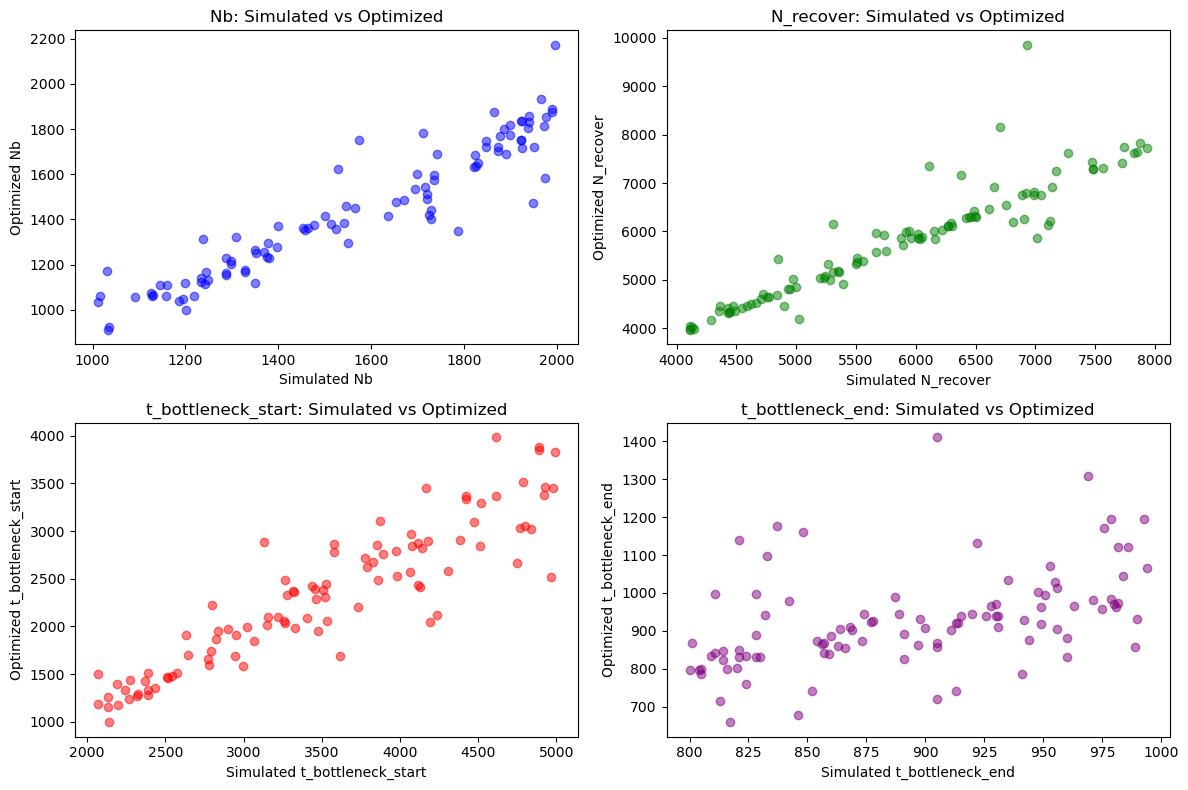

In [398]:
visualizing_results(dadi_results)

opt_params structure: [[{'N0': 8014, 'Nb': 1923.5824624005713, 'N_recover': 4681.625421534208, 't_bottleneck_end': 917.5209655227073, 't_bottleneck_start': 2266.248194223852}], [{'N0': 9829, 'Nb': 1759.676523418305, 'N_recover': 6873.093120075028, 't_bottleneck_end': 909.8836485789726, 't_bottleneck_start': 3753.80292482408}], [{'N0': 8439, 'Nb': 2671.0537216546627, 'N_recover': 6495.200828366552, 't_bottleneck_end': 537.4313342792374, 't_bottleneck_start': 3494.184663863689}], [{'N0': 9836, 'Nb': 2117.7708203035686, 'N_recover': 6284.334015132403, 't_bottleneck_end': 855.6741413864254, 't_bottleneck_start': 1455.0378821522615}], [{'N0': 8146, 'Nb': 943.8529844139637, 'N_recover': 6634.13011046862, 't_bottleneck_end': 1824.9042686064956, 't_bottleneck_start': 1365.1431925494085}], [{'N0': 9066, 'Nb': 1378.5116338786036, 'N_recover': 7134.396668868044, 't_bottleneck_end': 756.596371432501, 't_bottleneck_start': 3198.356424695814}], [{'N0': 9197, 'Nb': 1824.2847470960191, 'N_recover': 50

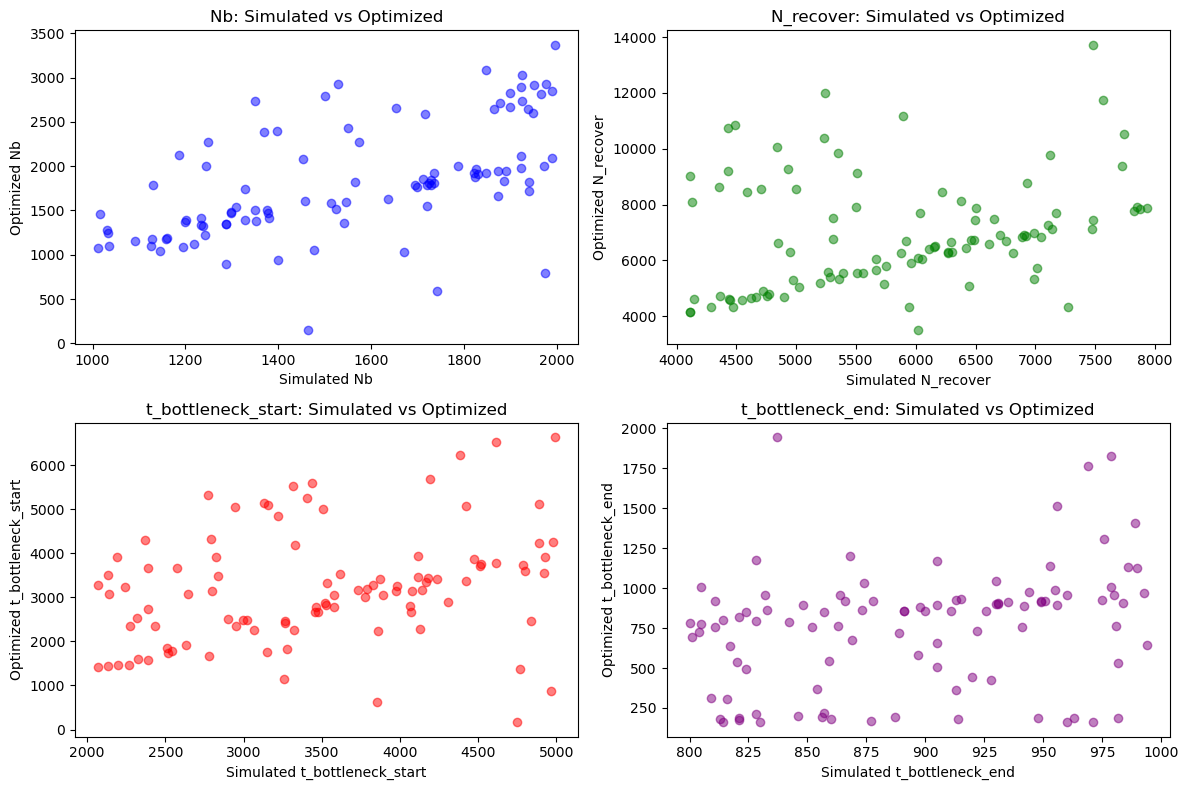

In [399]:
visualizing_results(moments_results)

## XGBoostin

In [404]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import numpy as np



Define the features and targets

In [405]:
import numpy as np

# Extract parameters from dadi_results

# Flattening the nested lists of dictionaries for dadi and moments results
opt_params_flat_dadi = [item for sublist in dadi_results['opt_params'] for item in sublist]
opt_params_flat_moments = [item for sublist in moments_results['opt_params'] for item in sublist]

sample_params_flat = [item for sublist in dadi_results['simulated_params'] for item in sublist]


# Extracting parameters from the flattened lists
Nb_opt_dadi = [d['Nb'] for d in opt_params_flat_dadi]
N_recover_opt_dadi = [d['N_recover'] for d in opt_params_flat_dadi]
t_bottleneck_start_opt_dadi = [d['t_bottleneck_start'] for d in opt_params_flat_dadi]
t_bottleneck_end_opt_dadi = [d['t_bottleneck_end'] for d in opt_params_flat_dadi]

Nb_opt_moments = [d['Nb'] for d in opt_params_flat_moments]
N_recover_opt_moments = [d['N_recover'] for d in opt_params_flat_moments]
t_bottleneck_start_opt_moments = [d['t_bottleneck_start'] for d in opt_params_flat_moments]
t_bottleneck_end_opt_moments = [d['t_bottleneck_end'] for d in opt_params_flat_moments]

Nb_sample = [d['Nb'] for d in dadi_results['simulated_params']]
N_recover_sample = [d['N_recover'] for d in dadi_results['simulated_params']]
t_bottleneck_start_sample = [d['t_bottleneck_start'] for d in dadi_results['simulated_params']] 
t_bottleneck_end_sample = [d['t_bottleneck_end'] for d in dadi_results['simulated_params']] 

# Combine the parameters into columns
Nb_opt = np.column_stack((Nb_opt_dadi, Nb_opt_moments))
N_recover_opt = np.column_stack((N_recover_opt_dadi, N_recover_opt_moments))
t_bottleneck_start_opt = np.column_stack((t_bottleneck_start_opt_dadi, t_bottleneck_start_opt_moments))
t_bottleneck_end_opt = np.column_stack((t_bottleneck_end_opt_dadi, t_bottleneck_end_opt_moments))

# Put all these features into a single 2D array
opt_params_array = np.column_stack((
    Nb_opt,
    N_recover_opt,
    t_bottleneck_start_opt,
    t_bottleneck_end_opt
))

# Combine simulated parameters into targets
targets = np.column_stack((Nb_sample, N_recover_sample, t_bottleneck_start_sample, t_bottleneck_end_sample))

# Features are the optimized parameters
features = opt_params_array

In [406]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, verbosity = 2)

# Wrap the XGBoost model with MultiOutputRegressor
multi_output_model = MultiOutputRegressor(xgb_model)

# Train the model
multi_output_model.fit(X_train, y_train)

# Make predictions
y_pred = multi_output_model.predict(X_test)


In [407]:
# Evaluate the model

# Squared difference between prediction and true value, normalized by the true value
relative_squared_errors = ((y_pred - y_test) / y_test) ** 2

# Sum the relative squared errors across all columns and take the square root
sum_relative_squared_errors = np.sqrt(np.sum(relative_squared_errors, axis = 0))

print(f"Parameter-specific MSE: {sum_relative_squared_errors}")

Parameter-specific MSE: [0.34131358 0.3013334  0.34941675 0.33054226]


Now let's look at parameter-specific error before ML

In [408]:
# Dadi Error Results

# Calculate the relative squared errors for each column
relative_squared_errors = ((X_test[:,[0,2,4,6]] - y_test) / y_test) ** 2

# Sum the relative squared errors across all columns and take the square root
sum_relative_squared_errors = np.sqrt(np.sum(relative_squared_errors, axis = 0))
# result = np.sqrt(sum_relative_squared_errors)

print(f"Parameter-specific MSE: {sum_relative_squared_errors}")

Parameter-specific MSE: [0.44879492 0.2634564  1.56287907 0.63365268]


In [409]:
# Moments Error Results

# Calculate the relative squared errors for each column
relative_squared_errors = ((X_test[:,[1,3,5,7]] - y_test) / y_test) ** 2

# Sum the relative squared errors across all columns and take the square root
sum_relative_squared_errors = np.sqrt(np.sum(relative_squared_errors, axis = 0))
# result = np.sqrt(sum_relative_squared_errors)

print(f"Parameter-specific MSE: {sum_relative_squared_errors}")

Parameter-specific MSE: [1.6339932  1.81698956 1.89443381 2.36305475]


### Interpretability

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import shap
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import learning_curve

In [410]:
# Feature names dictionary
feature_names = {
    0: 'Nb_opt_dadi',
    1: 'Nb_opt_moments',
    2: 'N_recover_opt_dadi',
    3: 'N_recover_opt_moments',
    4: 't_bottleneck_start_opt_dadi',
    5: 't_bottleneck_start_opt_moments',
    6: 't_bottleneck_end_opt_dadi',
    7: 't_bottleneck_end_opt_moments'
}

In [411]:
import re

In [414]:
def feature_importance(model_number, feature_names, fileprefix = 'feature_importance'):
    # Plot feature importance for each output
    first_output_model = multi_output_model.estimators_[model_number]
    fig, ax = plt.subplots()
    xgb.plot_importance(first_output_model, ax=ax)
    plt.title(f'Feature importance for output {model_number}')
    
    # Replace the feature indices with their names using the feature_names dictionary
    labels = ax.get_yticklabels()
    new_labels = []
    for label in labels:
        text = label.get_text()
        index = int(re.findall(r'\d+', text)[0])  # Extract the index
        new_labels.append(feature_names.get(index, text))  # Use the dictionary to get the name

    # Set the ticks and the new labels
    ax.set_yticks(ax.get_yticks())  # Fix the number of ticks
    ax.set_yticklabels(new_labels)

    # Save the plot as a PDF
    file_name = f'{fileprefix}_output_{feature_names[model_number]}.pdf'
    plt.savefig(file_name, format='pdf')
    plt.show()

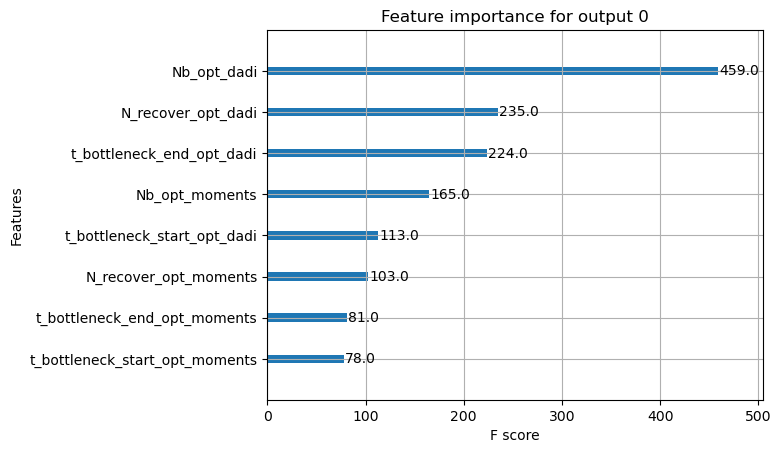

In [415]:
feature_importance(0, feature_names=feature_names)

Basically this is the feature importance plot for the XGB model predicting the Bottleneck size. We see that dadi's inference for the bottleneck size is the best predictor for the actual bottleneck size

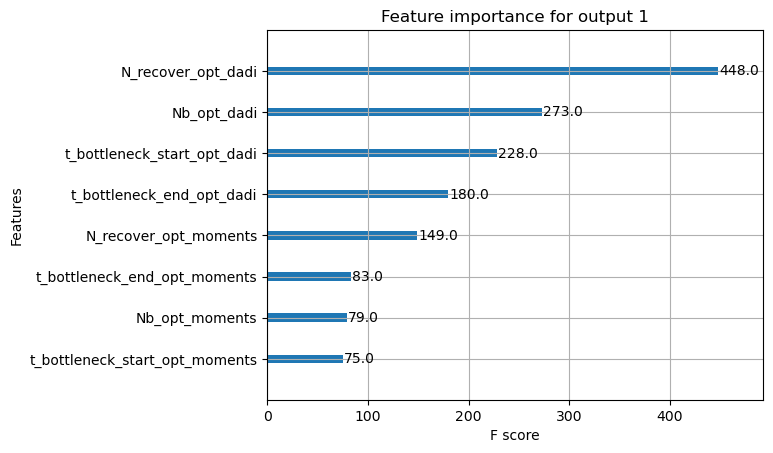

In [416]:
feature_importance(1, feature_names=feature_names)

Dadi's estimate of the recovery population size is the best predictor for the actual recovery population size

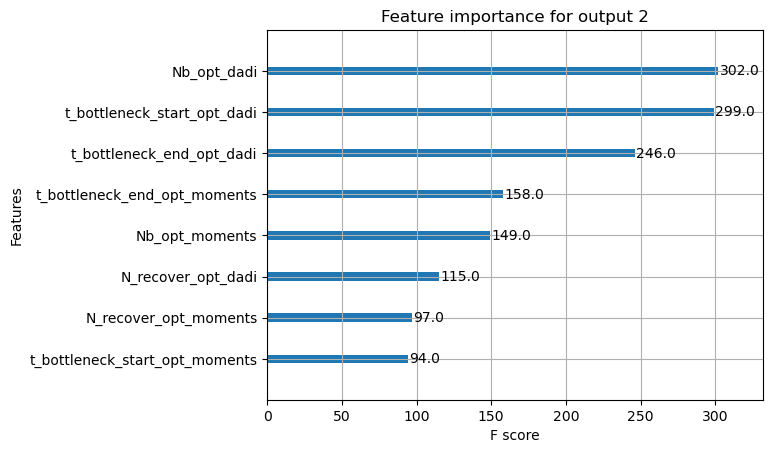

In [417]:
feature_importance(2, feature_names=feature_names)

Dadi's estimate of the bottleneck size is the best predictor for the time in the bottleneck. This is closely followed up by dadi's estimate of the time inside the bottlneck. 

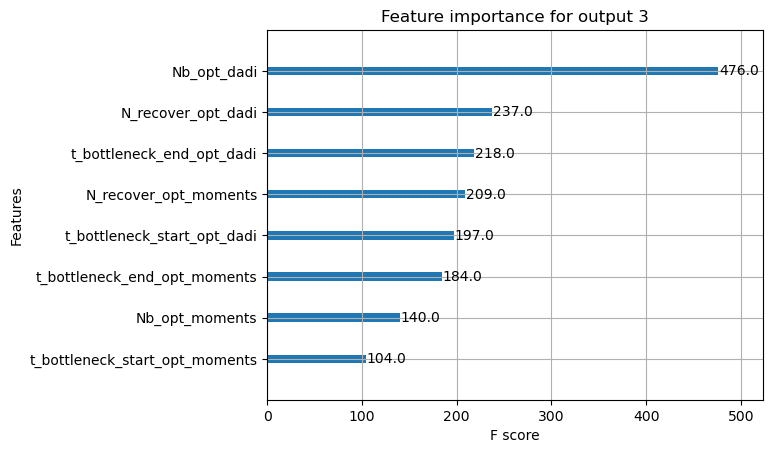

In [418]:
feature_importance(3, feature_names=feature_names)

This is a bit weird. Dadi's estimate of the bottleneck size is the best predictor of the recovery time after the bottleneck.

In [420]:
def visualize_model_predictions(y_test, y_pred, output_number, fileprefix='model_predictions'):
    # Plot the true values against the predicted values for the first output
    plt.scatter(y_test[:, output_number], y_pred[:, output_number])
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title(f'True vs predicted values for output {output_number}')

    # Save the plot as a PDF
    file_name = f'{fileprefix}_output_{output_number}.pdf'
    plt.savefig(file_name, format='pdf')
    plt.show()

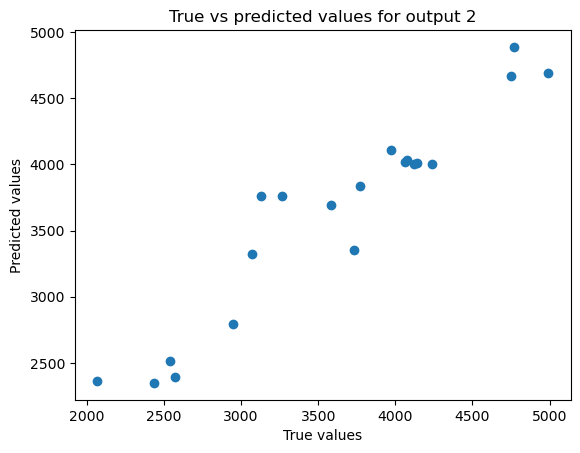

In [424]:
visualize_model_predictions(y_test, y_pred, 2)

In [425]:
def shap_values_plot(X_test, index, fileprefix='shap_values'):
    
    output_model = multi_output_model.estimators_[index]
    # Create a SHAP explainer
    explainer = shap.Explainer(output_model)

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test)

    # Plot the SHAP values
    shap.summary_plot(shap_values, X_test, plot_type='bar')

    # Save the plot as a PDF
    file_name = f'{fileprefix}_feature_{index}.pdf'
    plt.savefig(file_name, format='pdf')
    plt.show()

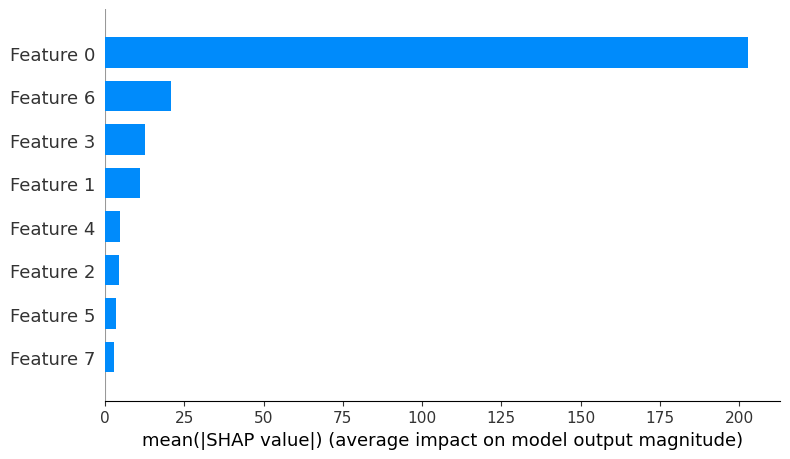

<Figure size 640x480 with 0 Axes>

In [426]:
shap_values_plot(X_test, index = 0)

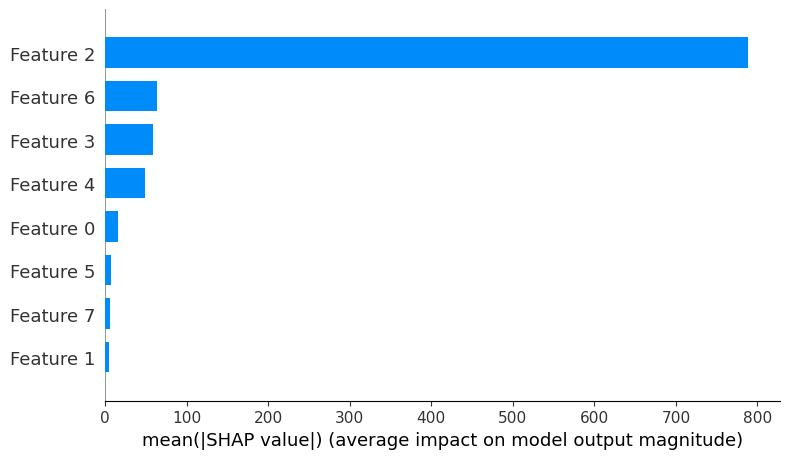

<Figure size 640x480 with 0 Axes>

In [427]:
shap_values_plot(X_test, index = 1)

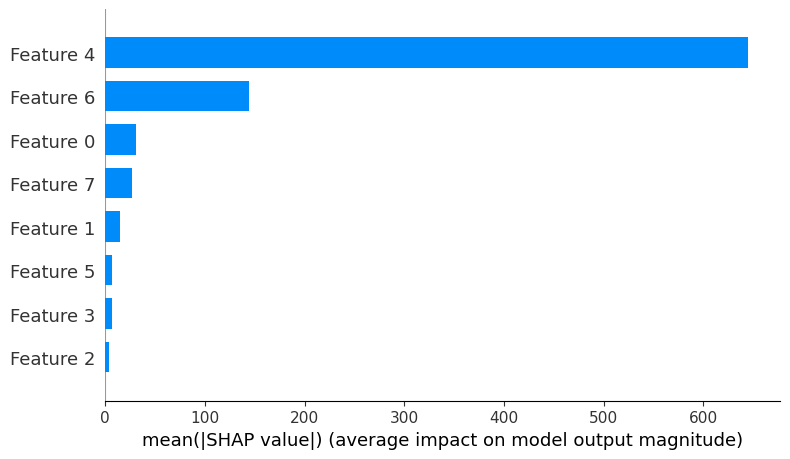

<Figure size 640x480 with 0 Axes>

In [428]:
shap_values_plot(X_test, index = 2)

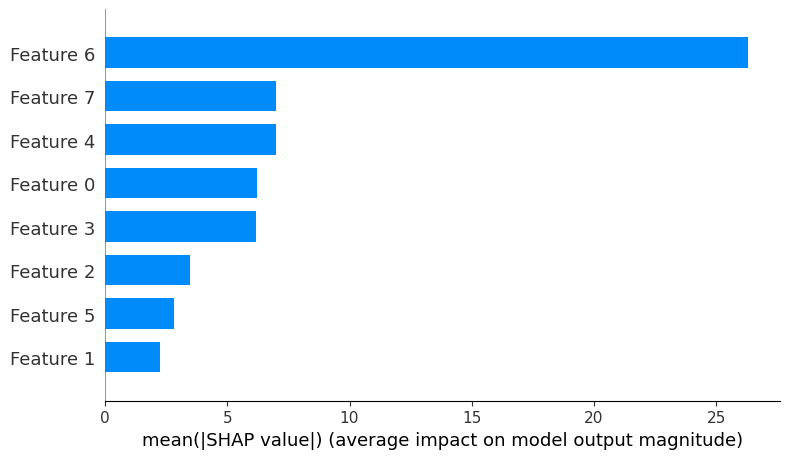

<Figure size 640x480 with 0 Axes>

In [429]:
shap_values_plot(X_test, index = 3)

In [430]:
def partial_dependence_plots(X_test, index, features, fileprefix='partial_dependence'):
    output_model = multi_output_model.estimators_[index]

    # Partial dependence plots for the first output
    fig, ax = plt.subplots(4, 2, figsize=(12, 10))  # Adjust the figure size
    PartialDependenceDisplay.from_estimator(output_model, X_test, features, ax=ax)
    plt.suptitle(f'Partial Dependence Plots for output {index}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

    # Save the plot as a PDF
    file_name = f'{fileprefix}_feature_{index}.pdf'
    plt.savefig(file_name, format='pdf')
    plt.show()

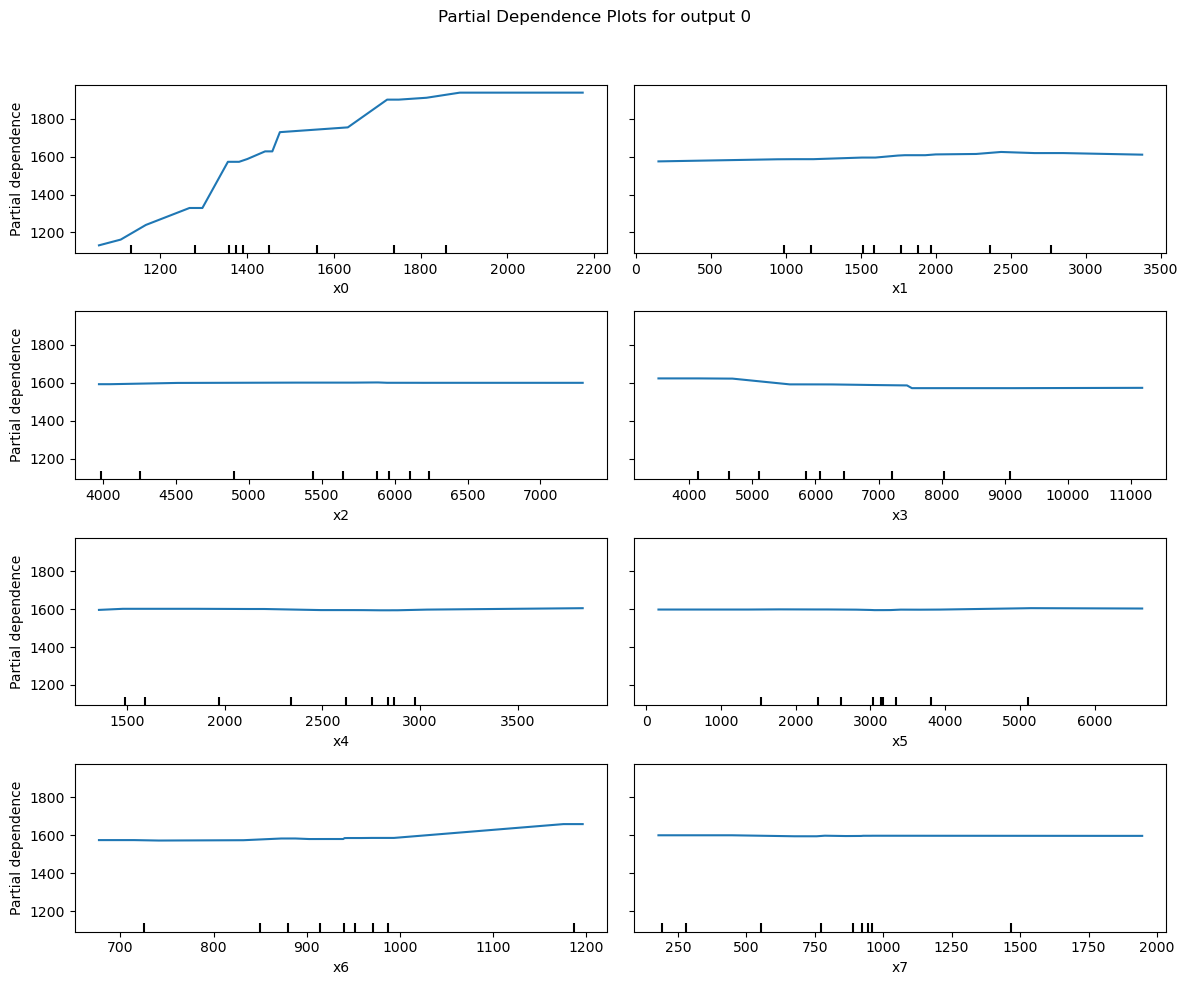

<Figure size 640x480 with 0 Axes>

In [431]:
partial_dependence_plots(X_test, 0, [0, 1, 2, 3, 4, 5, 6, 7])

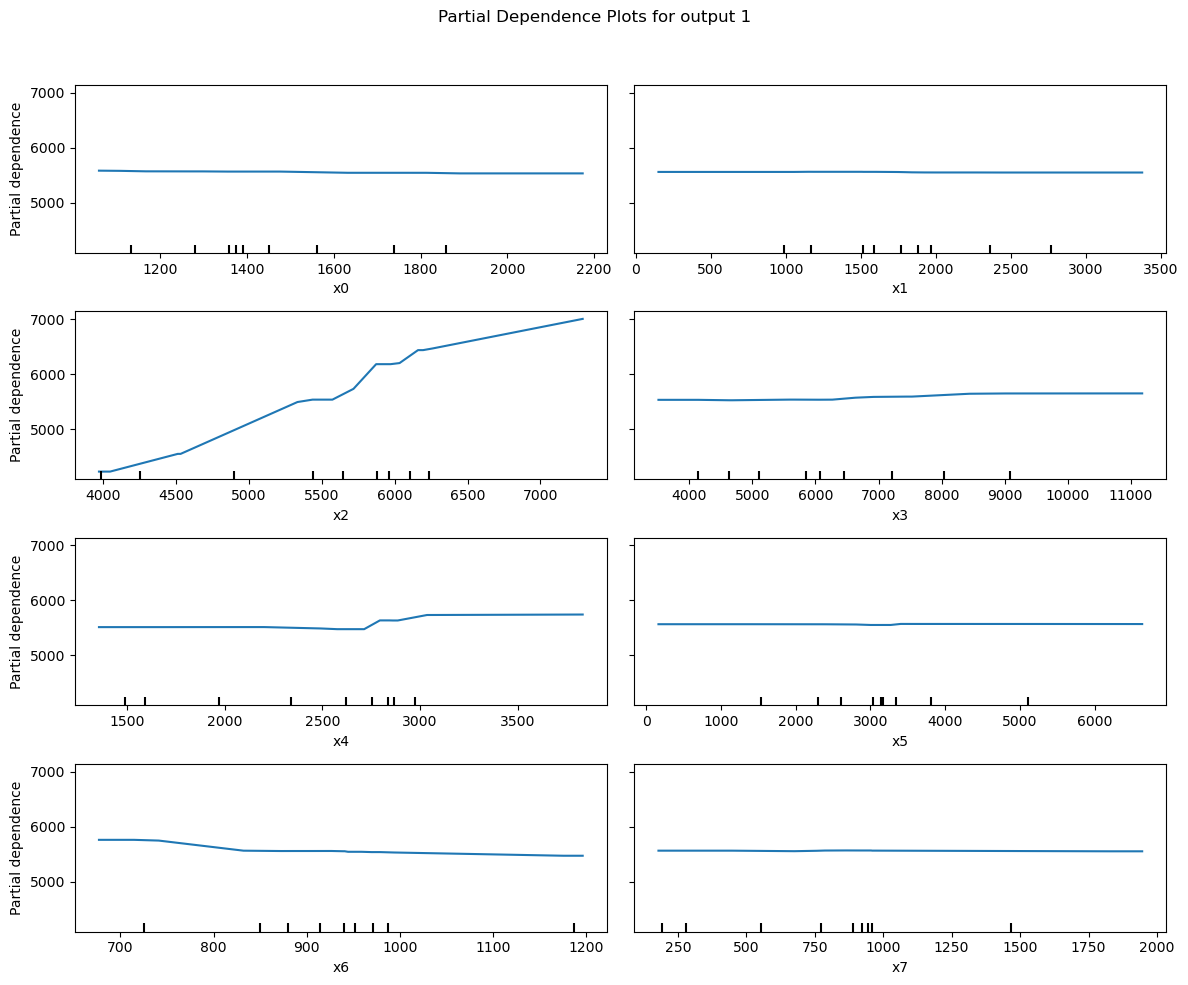

<Figure size 640x480 with 0 Axes>

In [432]:
partial_dependence_plots(X_test, 1, [0, 1, 2, 3, 4, 5, 6, 7])

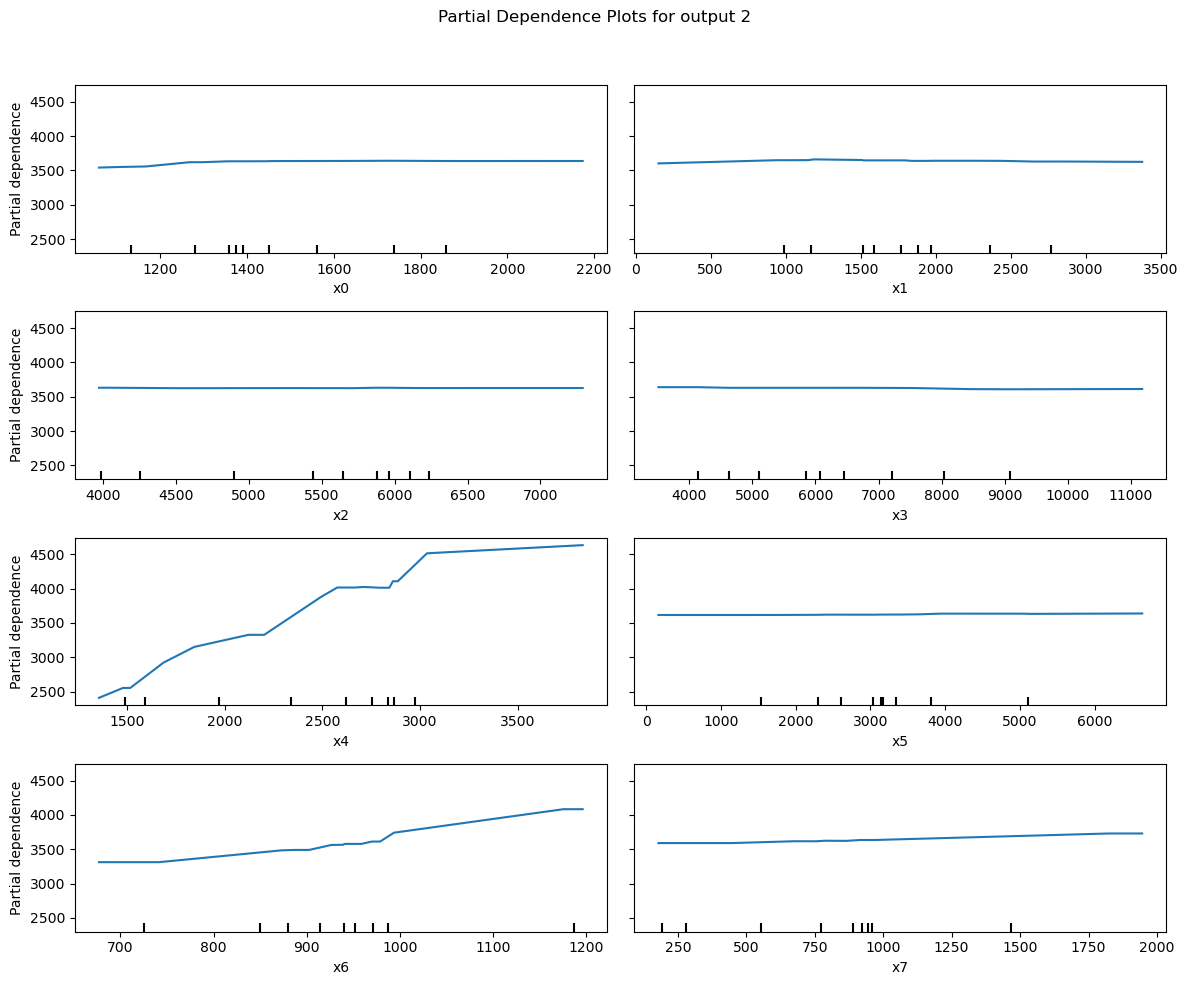

<Figure size 640x480 with 0 Axes>

In [433]:
partial_dependence_plots(X_test, 2, [0, 1, 2, 3, 4, 5, 6, 7])

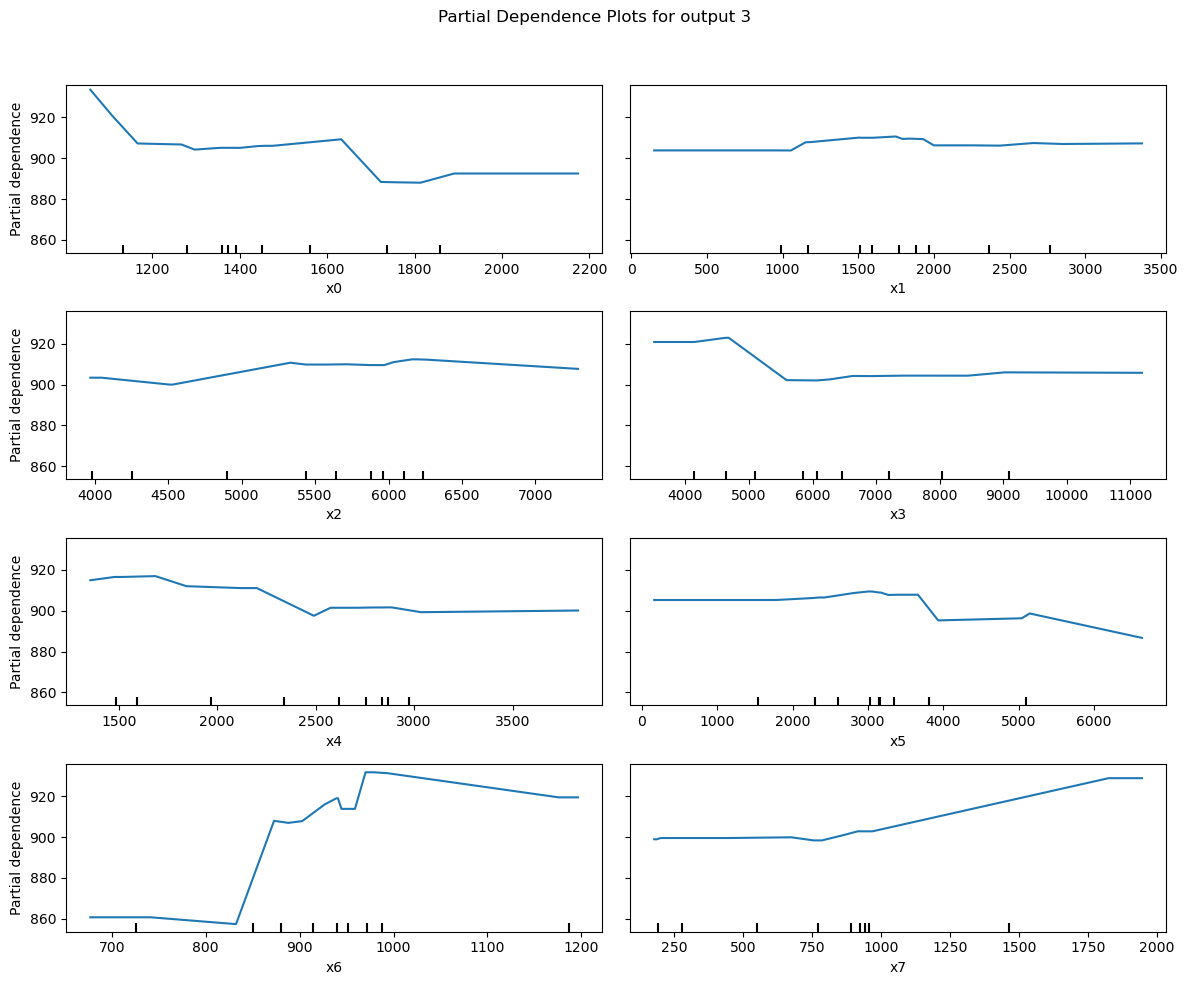

<Figure size 640x480 with 0 Axes>

In [434]:
partial_dependence_plots(X_test, 3, [0, 1, 2, 3, 4, 5, 6, 7])

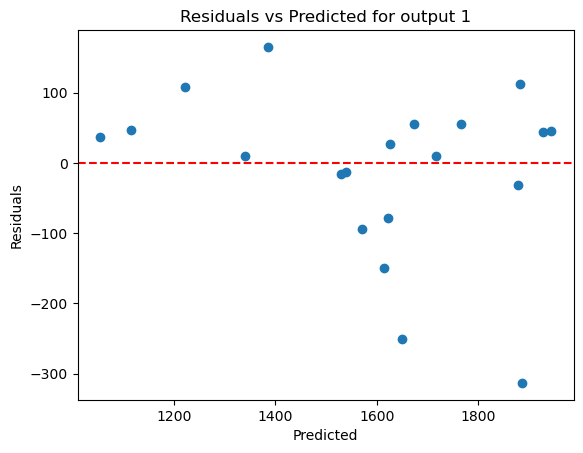

In [435]:
# Residual plot for the first output
residuals = y_test[:, 0] - y_pred[:, 0]
plt.scatter(y_pred[:, 0], residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted for output 1')
plt.axhline(0, color='red', linestyle='--')
plt.show()